In [65]:
import coffea
from coffea.nanoevents.methods import vector
import coffea.hist as hist
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import sys,os

# from pyjet import cluster
import awkward as ak

from sklearn.cluster import DBSCAN

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema,BaseSchema

sys.path.append(os.getcwd().replace('scripts', 'lib'))
import util

# from numba import jit

# Open data files

 * First file contains collision data taken with large MET in the trigger in 2016. This is a sub-set of the analysis nTuple that you will use in the rest of the exercise.
 * The 2nd file contains signal simulation with $H\rightarrow SS \rightarrow 4b$ events

In [66]:
fpath = "/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/data/displacedJetMuon_ntupler.root"
data = NanoEventsFactory.from_root(fpath,
                                   schemaclass=BaseSchema,
                                   treepath="ntuples/llp"
                                  ).events()

fpath ="/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/signal/displacedJetMuon_ntupler.root"

signal = NanoEventsFactory.from_root(fpath,
                                   schemaclass=BaseSchema,
                                   treepath="ntuples/llp"
                                  ).events()

## The tree is loaded with the "coffea" analysis framework
The events are loaded into an "awkward arrays", i.e. arrays with irregular sizes
Our event-based data fits into awkward arrays very naturally!
 - Tree:
 -  |-muonPt :[ [Pt1,Pt2], [Pt1] ...]
 -  |-muonEta:[ [Eta1,Eta2], [Eta1] ...]

In [67]:
# this awkward array has 16965 events, of the type "event"
data

<NanoEventsArray [{isData: True, nPV: 12, ... -666]}] type='16965 * event'>

In [68]:
# shows the branches of the tree
data.fields

['isData',
 'nPV',
 'runNum',
 'nSlimmedSecondV',
 'lumiNum',
 'eventNum',
 'eventTime',
 'pvX',
 'pvY',
 'pvZ',
 'fixedGridRhoAll',
 'fixedGridRhoFastjetAll',
 'fixedGridRhoFastjetAllCalo',
 'fixedGridRhoFastjetCentralCalo',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'fixedGridRhoFastjetCentralNeutral',
 'nPVAll',
 'pvAllX',
 'pvAllY',
 'pvAllZ',
 'pvAllLogSumPtSq',
 'pvAllSumPx',
 'pvAllSumPy',
 'nBunchXing',
 'BunchXing',
 'nPU',
 'nPUmean',
 'nMuons',
 'muonE',
 'muonPt',
 'muonEta',
 'muonPhi',
 'muonCharge',
 'muonIsLoose',
 'muonIsMedium',
 'muonIsTight',
 'muon_d0',
 'muon_dZ',
 'muon_ip3d',
 'muon_ip3dSignificance',
 'muonType',
 'muonQuality',
 'muon_pileupIso',
 'muon_chargedIso',
 'muon_photonIso',
 'muon_neutralHadIso',
 'muon_ptrel',
 'muon_chargedMiniIso',
 'muon_photonAndNeutralHadronMiniIso',
 'muon_chargedPileupMiniIso',
 'muon_activityMiniIsoAnnulus',
 'muon_passSingleMuTagFilter',
 'muon_passHLTFilter',
 'muon_validFractionTrackerHits',
 'muon_isGlobal',
 'muon_no

## Accessing a branch like this will give the data in the format of (awkward)arrays
 - Note that the type becomes "int32"
 - For event-level quantity (number of total rechits),
   the length of array is the **same** as the number of events

In [69]:
data.ncscRechits

<Array [41, 56, 25, 10, 64, ... 8, 48, 52, 52] type='16965 * int32[parameters={"...'>

 - For object-level quantity (X pos. of each rechit), the first dimension of array is the same as the number of events, but the 2nd dimension of the array is **variable (var, float32)** 

In [70]:
data.cscRechitsX

<Array [[116, 116, 116, ... -117, -133, -117]] type='16965 * var * float32[param...'>

## Pack all the rechit properties arrays in 1 object

In [71]:
def pack(events,obj_str):
    obj  = ak.zip(
                {k.replace(obj_str,""):getattr(events,k) for k in events.fields if k.startswith(obj_str)}
                ,with_name="PtEtaPhiMLorentzVector",
                behavior=vector.behavior
               )
    return obj

In [72]:
rechits = pack(data,"cscRechits")

In [82]:
d_rechits = rechits
s_rechits = pack(signal,"cscRechits")

 - These properties mostly follow from the CMSSW definition: [here](https://github.com/cms-sw/cmssw/blob/master/DataFormats/CSCRecHit/interface/CSCRecHit2D.h)
 - Our nTuplizer only dropped a few properties and computed a few new ones
 - We will use the following properties:
   - Eta,Phi
   - X,Y,Z
   - Tpeak (Time calculated from strip input), Twire (Time calculated from wire input) [src code](https://github.com/cms-sw/cmssw/blob/master/RecoLocalMuon/CSCRecHitD/src/CSCMake2DRecHit.cc)
   - Station

In [73]:
rechits.fields

['Phi',
 'Eta',
 'X',
 'Y',
 'Z',
 'E',
 'Tpeak',
 'Twire',
 'Quality',
 'Chamber',
 'Station',
 'ClusterId',
 'Channels',
 'NStrips',
 'HitWire',
 'WGroupsBX',
 'NWireGroups',
 'DetId']

In [74]:
# Check number of rechits per event
ak.num(rechits)

<Array [41, 56, 25, 10, 64, ... 8, 48, 52, 52] type='16965 * int64'>

## Look at the 2D event display of rechits

In [75]:
def displayRZ(i_event,rechits=[],cls=[]):
    plt.style.use(hep.style.CMS) 
    
    #Select the rechits in the i-th event
    i_rh = rechits[i_event] if len(rechits)>0 else None
    i_cls = cls[i_event] if len(cls)>0 else None
    
    #Make a figure with 2 subplots
    fig, axs = plt.subplots(1,2, figsize=(18,8))

    axs = axs.flatten()
    #plot clusters:
    if len(cls)>0:
        #Eta-phi plot:        
        s1=axs[0].scatter(i_cls.Eta,i_cls.Phi,s=i_cls.Nhit,label="Cluster")
        for cl in i_cls:
            cone = plt.Circle((cl.Eta, cl.Phi), 0.4, color='b', fill=False,)
            axs[0].add_patch(cone)        
        
        #R-Z plot:        
        cls_r = (i_cls.X**2+i_cls.Y**2)**0.5        
        axs[1].scatter(np.abs(i_cls.Z),cls_r,s=i_cls.Nhit)            
    
    #plot rechits:
    if len(rechits)>0:
        #Eta-phi plot:
        s2=axs[0].scatter(i_rh.Eta,i_rh.Phi,s=1,label="Rechits")
        rh_r = (i_rh.X**2+i_rh.Y**2)**0.5    
        
        #R-Z plot:        
        axs[1].scatter(np.abs(i_rh.Z),rh_r,s=1)

    #label eta-phi plot
    axs[0].text(0.1,0.9,"%s-th event"%i_event,transform=axs[0].transAxes)
    axs[0].set_ylim(-np.pi,np.pi)
    axs[0].set_xlim(-5,5)
    axs[0].set_ylabel(r"$\phi$")
    axs[0].set_xlabel(r"$\eta$")
    
    #label RZ plot
    MB_xmin = 300
    util.drawRZ(axs[1],MB_xmin)
    axs[1].set_xlim(MB_xmin,None)
    axs[1].set_xlabel("|z|[cm]")
    axs[1].set_ylabel("R[cm]")
    
    #make legend
    handles, labels = [(a + b) for a, b in zip(axs[0].get_legend_handles_labels(), 
                                           axs[1].get_legend_handles_labels())]
    leg=fig.legend(handles, labels,
                   bbox_to_anchor=(1.0, 1.0), loc='upper left')   
    for ax in axs:
        hep.cms.label(ax=ax,data=True,label="Preliminary")    
    for l in leg.legendHandles:
        l._sizes = [30]
    plt.tight_layout()
    return

### Try to look at the rechits from different events!
Hint: find an event that has a large number of rechits first to get an interesting event!

In [76]:
# check which events have large number of rechits
np.where(ak.num(rechits)>400)

(<Array [162, 501, 2194, ... 15396, 16922] type='38 * int64'>,)

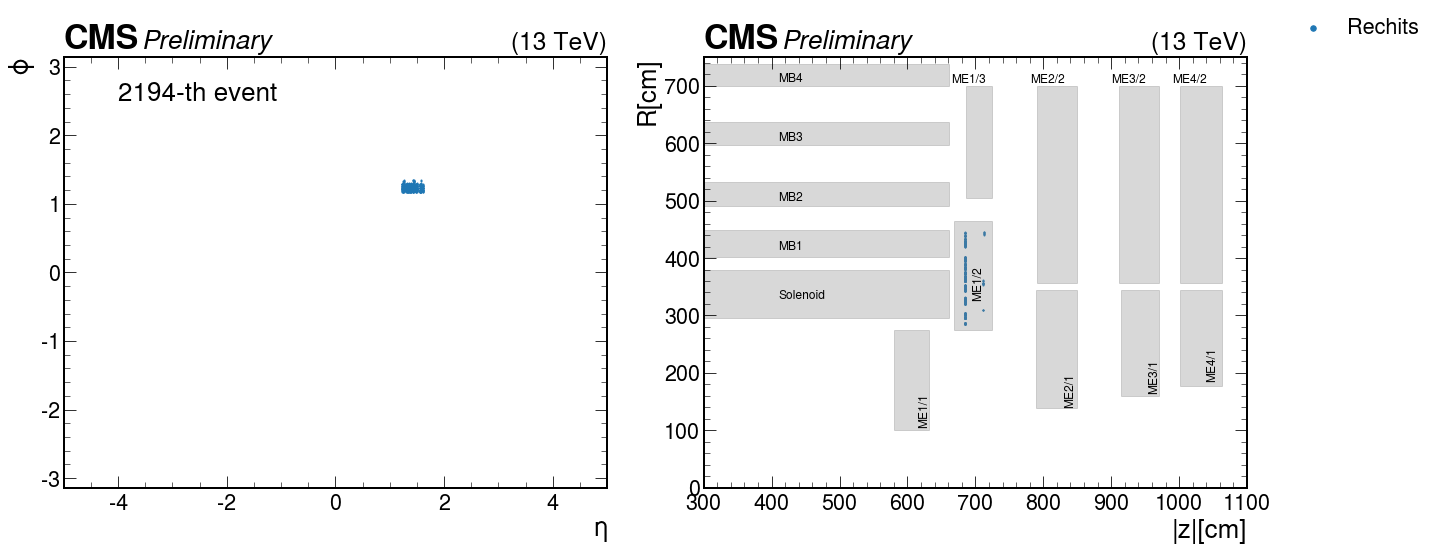

In [78]:
displayRZ(2194,rechits)

# Clustering the rechits

### First read the discussion in the lesson: [link](https://christinaw97.github.io/MDS_CMSDAS/03-MDS_reco/index.html#clustering-algorithm)

We are using DBSCAN algorithm, implemented with the python lib: `sklearn.cluster`

In [80]:
def DBScan(rechits,nCore,eps):
    points=ak.zip([rechits.Eta,rechits.Phi],highlevel=False)

    all_clusters = []
    for x,rechit in zip(points,rechits):
        n_clusters_=0
        core_samples_mask=[]
        ## format into DBSCAN input format x=[ [x1,y1],[x2,y2] ... ]        
        x=np.stack(ak.unzip(x),axis=1)
        i_clusters = []        
        if len(x)>0:            
            db = DBSCAN(eps=eps, min_samples=nCore).fit(x)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_    
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            ## Loop over clusters in this event
            for iCs in range(n_clusters_):

                #Compute each cluster's properties:
                #    Input = rechits that belongs to this cluster (done via array masking)
                cls = computeCluster(rechit[labels==iCs])
                i_clusters.append(cls)
        all_clusters.append(i_clusters)
    return ak.Array(all_clusters)

def computeCluster(rechits):
    cls = {}

    cls["Nhit"] = len(rechits)
    cls["Eta"] = np.mean(rechits.Eta)
    cls["Phi"] = np.mean(rechits.Phi)
    cls["X"] = np.mean(rechits.X)
    cls["Y"] = np.mean(rechits.Y)    
    cls["Z"] = np.mean(rechits.Z)        
    cls["Time"]= np.mean((rechits.Tpeak + rechits.Twire)/2)

    avgStation10,nStation10 = computeStationProp(rechits)
    nME11_12 = computeME11_12(rechits)
    
    cls["nStation10"] = nStation10
    cls['avgStation10'] = avgStation10
    cls["nME11_12"] = nME11_12
    
    return cls

def computeStationProp(rechits):
#     uniqueStations = np.unique(rechits.Station)    
    uniqueStations = np.array([-4,-3,-2,-1,1,2,3,4])    
    nStation10   = 0
    avgStation10 = 0
    TotHitsStation10 = 0
    for i_station in uniqueStations:
        nRechit_in_i_station = sum(rechits.Station==i_station)
        if nRechit_in_i_station >=10:
            nStation10 +=1
            avgStation10 += i_station * nRechit_in_i_station
            TotHitsStation10 += nRechit_in_i_station
    avgStation10 = avgStation10/TotHitsStation10
    return avgStation10,nStation10

def computeME11_12(rechits):
    return ak.sum((abs(rechits.Chamber)==11)|(abs(rechits.Chamber)==12))

In [81]:
%%time

minPoint = 50
dR = 0.2
cls = DBScan(rechits,minPoint,dR)

CPU times: user 1min 22s, sys: 1.04 s, total: 1min 23s
Wall time: 1min 23s


In [84]:
d_cls = cls
s_cls = DBScan(s_rechits,minPoint,dR)

In [83]:
cls.fields

['Nhit',
 'Eta',
 'Phi',
 'X',
 'Y',
 'Z',
 'Time',
 'nStation10',
 'avgStation10',
 'nME11_12']

## Try to see if the cluster in the previous event makes sense!
Hint: find an event that has a reconstructed cluster first

Do you see a cluster in the event that you chose?

In [85]:
# check which events have more than 1 cluster
np.where(ak.num(cls)>=1)

(<Array [5, 29, 42, 52, ... 16925, 16957, 16959] type='1515 * int64'>,)

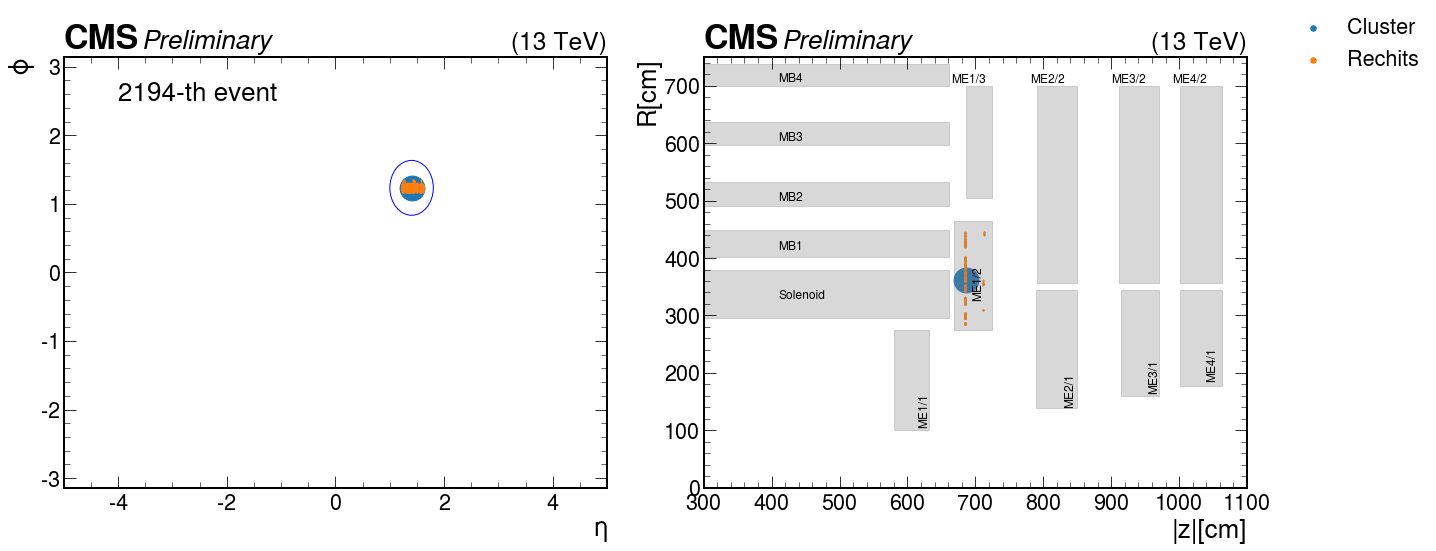

In [86]:
displayRZ(2194,rechits,cls)

# Examine cluster properties

In [87]:
samples=[
    {"cls":d_cls,"label":"data"}, 
    {"cls":s_cls,"label":"signal"},     
]
density=False

## Number of clusters and N_rechits

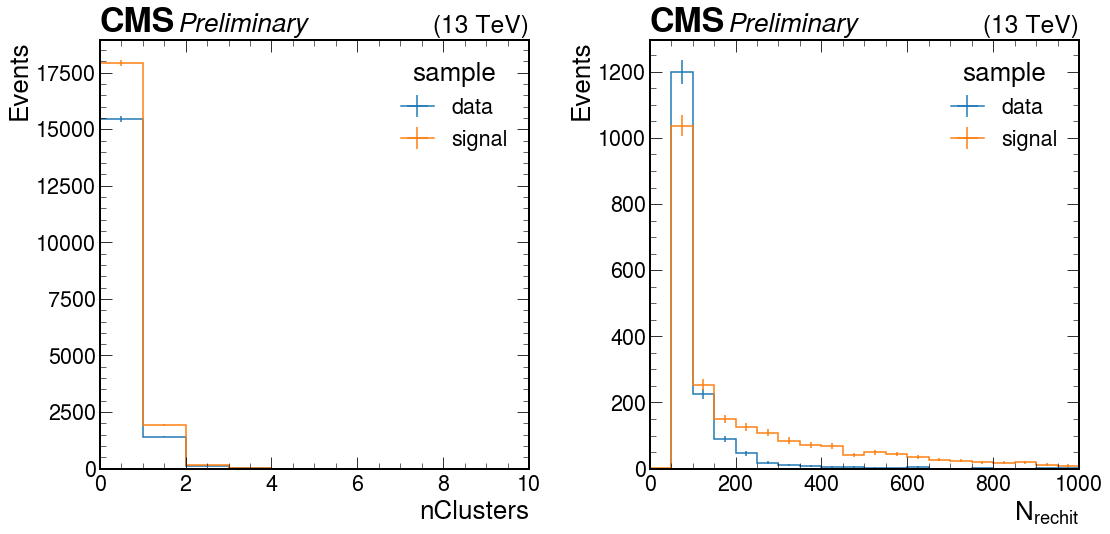

In [88]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Nhit", r"$N_{rechit}$", 20, 0, 1000))

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,nClusters=ak.num(cls))
    h2.fill(sample=label ,Nhit = ak.flatten(cls.Nhit))

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Eta, Phi distributions

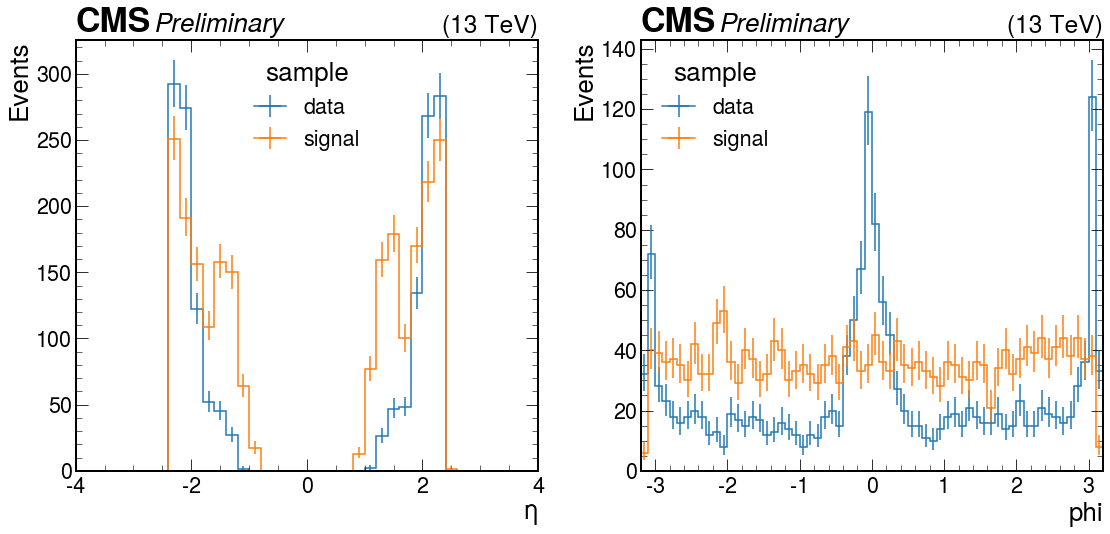

In [89]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("eta", r"$\eta$", 40, -4, 4))
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("phi", "phi", 64, -3.2, 3.2))

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,eta = ak.flatten(cls.Eta))
    h2.fill(sample=label ,phi = ak.flatten(cls.Phi))

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# R, Z distributions

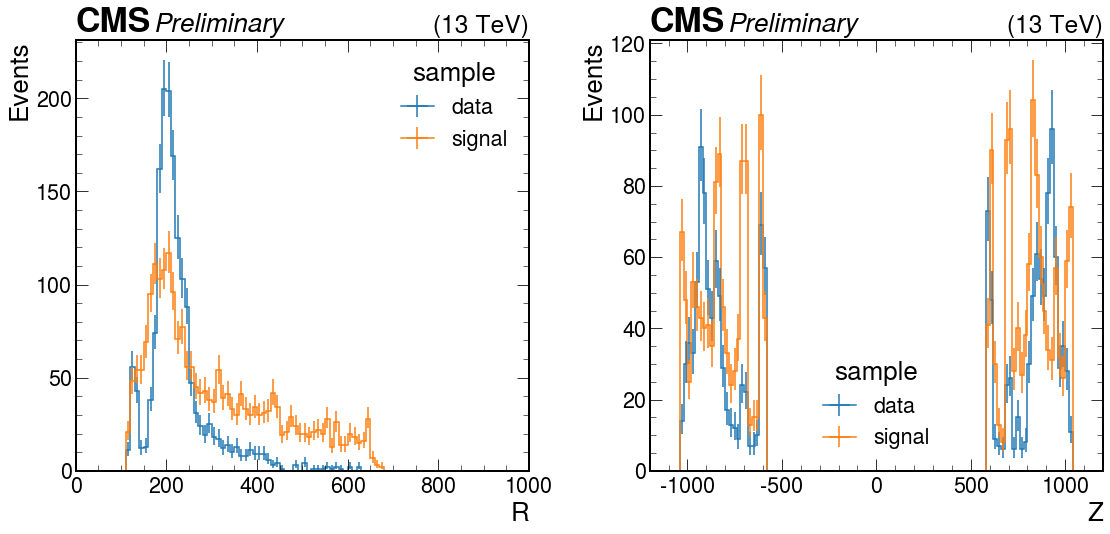

In [90]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h2 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("R", "R", 100, 0, 1000))        
h3 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Z", "Z", 120, -1200, 1200))            

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h2.fill(sample=label ,R = ak.flatten((cls.Y**2+cls.X**2)**0.5))
    h3.fill(sample=label ,Z = ak.flatten(cls.Z))        

hist.plot1d(h2,density=density,ax=axs[0])
hist.plot1d(h3,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Time, nStation10, AvgStation10 distributions

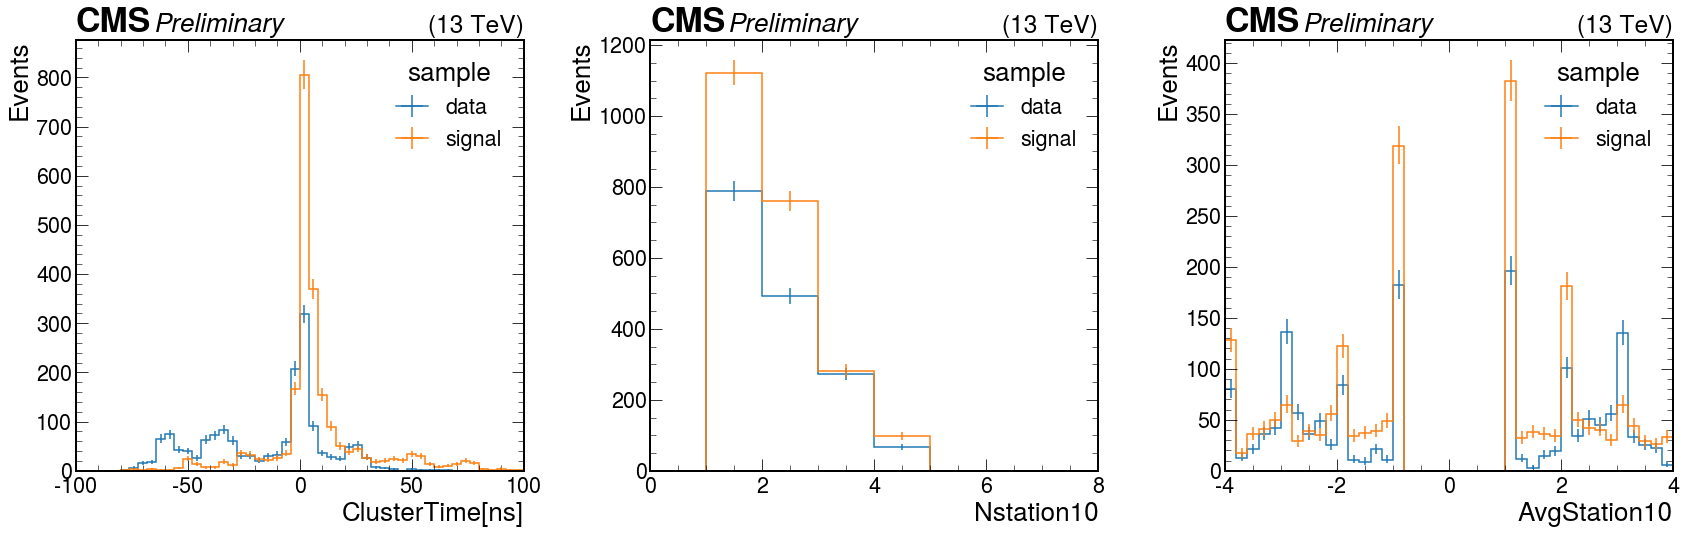

In [91]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,3,figsize=(24,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Time", 'ClusterTime[ns]',50, -100, 100))                        
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nStation10", "Nstation10", 8, 0, 8))    
h3= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("avgStation10", "AvgStation10", 40, -4, 4))             

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,Time = ak.flatten(cls.Time))
    h2.fill(sample=label ,nStation10 = ak.flatten(cls.nStation10))
    h3.fill(sample=label ,avgStation10 = ak.flatten(cls.avgStation10))    
    

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
hist.plot1d(h3,density=density,ax=axs[2])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Bonus: Cluster ID

Some combination of nStation10 and eta may also help us to distinguish between signal and background.
We will use these variable to design a "ClusterID" later.

In [92]:
h= hist.Hist("Events",
              hist.Bin("nStation10", "Nstation10", 8, 0, 8),
              hist.Bin("eta", r"$\eta$", 40, -3, 3)
             )    
h.fill(nStation10=ak.flatten(cls.nStation10),
      eta = ak.flatten(cls.Eta))
h_group = h.group("nStation10",hist.Cat("nStationGrp","nStationGrp"),
                 {
                     "nStation=1":slice(0,2),
                     "nStation>=1":slice(2,None),                     
                 })

<AxesSubplot:xlabel='$\\eta$', ylabel='Events'>

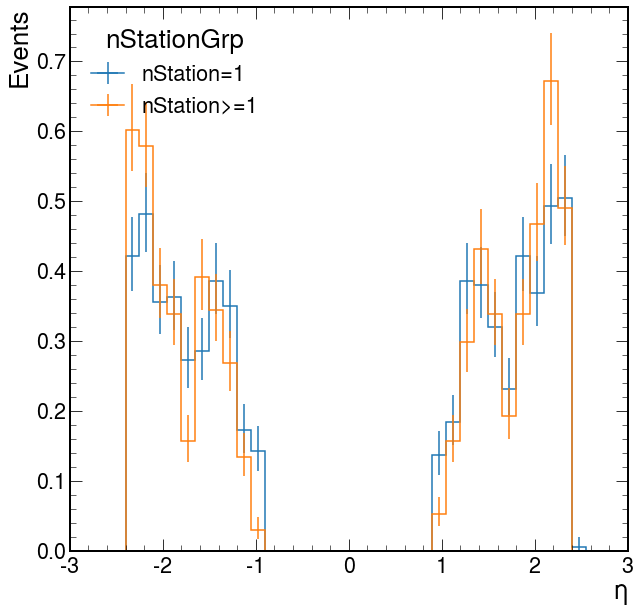

In [93]:
hist.plot1d(h_group,density=True)

(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7ff54ce07190>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff5494311f0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff5494171c0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])

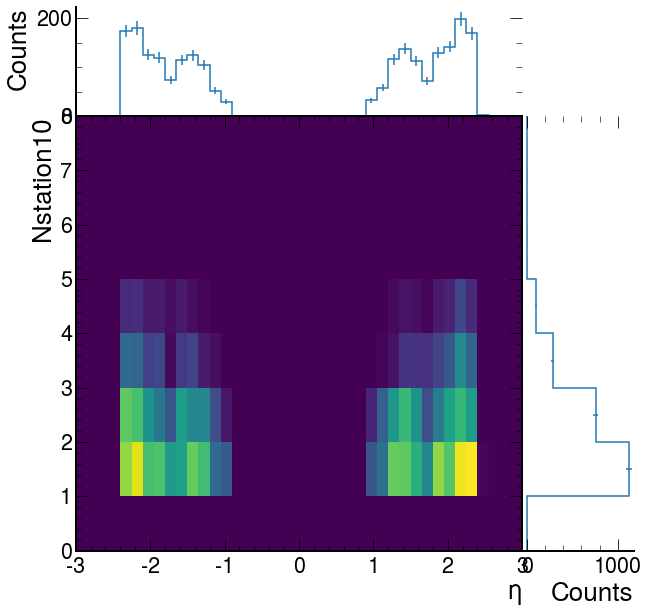

In [94]:
h.to_hist().project("eta","nStation10").plot2d_full()